# Imitation Learning with RL Finetuning through Self-Play

# Game Enviornment

In [1]:
import random
from collections import deque
import math
import numpy as np
from sklearn.model_selection import train_test_split
import json
import os

BOARD_SIZE = 4
ACTIONS = [0, 1, 2, 3]  # up,right, down, left

def add_tile(board):
    empty = list(zip(*np.where(board == 0)))
    if not empty:   # no empty cells
        return board
    y, x = random.choice(empty)
    board[y][x] = 1 if random.random() < 0.9 else 2
    return board

def move_right(board):
    new_board = np.zeros_like(board)
    reward = 0
    for row in range(BOARD_SIZE):
        tiles = board[row][board[row] != 0] # collect non-zero tiles
        merged = []
        skip = False
        for i in range(len(tiles)):
            if skip:
                skip = False
                continue
            if i + 1 < len(tiles) and tiles[i] == tiles[i+1]:
                merged.append(tiles[i] + 1)
                reward += 2 ** (tiles[i] + 1)  # calculate reward
                skip = True
            else:
                merged.append(tiles[i])
        new_board[row][:len(merged)] = merged
    return new_board, reward

def move(board, direction): 
    if direction == 0:  # up
        board = np.rot90(board, 1)
        new_board, reward = move_right(board)   #reuse this func to death bc im lazy lmao
        new_board = np.rot90(new_board, -1)
    elif direction == 2:  # down
        board = np.rot90(board, -1)
        new_board, reward = move_right(board)
        new_board = np.rot90(new_board)
    elif direction == 3:  # left
        new_board, reward = move_right(board)
    elif direction == 1:  # right
        board = np.fliplr(board)
        new_board, reward = move_right(board)
        new_board = np.fliplr(new_board)
    else:
        raise ValueError("Invalid direction")
    return new_board, reward

def is_game_over(board):
    for a in ACTIONS:
        new_board, _ = move(board, a)
        if not np.array_equal(new_board, board):
            return False
    return True

class Game2048Env:
    def reset(self):
        self.board = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
        self.board = add_tile(add_tile(self.board))
        return self.get_state()

    def step(self, action):
        # old_max_tile = np.max(self.board)
        old_board = self.board.copy()
        self.board, reward = move(self.board, action)
        changed = not np.array_equal(self.board, old_board)
        if changed: # only add a tile if the board changed
            self.board = add_tile(self.board)
        # new_max_tile = np.max(self.board)
        # reward = (new_max_tile > old_max_tile)  # reward for increasing max tile, small reward for merging
        done = is_game_over(self.board)
        return self.get_state(), reward, done

    def get_state(self):
        board = self.board.copy()
        board = np.where(board > 0, board, 0)
        board = board.astype(np.float32)
        board = board.reshape(1, 1, 4, 4)
        return board

# Enviornment Testing
for debugging purposes

In [ ]:
env = Game2048Env()
state = env.reset()
print("Initial board:")
print(env.board)

done = False
total_reward = 0

while not done:
    print("\nCurrent board:")
    print(env.board)

    move_str = input("Enter move (w=up, s=down, a=left, d=right, q=quit): ")
    if move_str == 'q':
        break
    move_map = {'w': 0, 'd': 1, 's': 2, 'a': 3}
    if move_str not in move_map:
        print("Invalid input.")
        continue

    action = move_map[move_str]
    prev_max = np.max(env.board)
    state, reward, done = env.step(action)
    new_max = np.max(env.board)

    print(f"Action: {move_str.upper()} | Reward: {reward:.2f} | Max tile: {2 ** new_max}")
    total_reward += reward

print("\nGame Over.")
print("Final board:")
print(env.board)
print(f"Total reward: {total_reward:.2f}")

# Import and Split Training Data

In [2]:
data_dir = "../data/"
X = []
Y = []

for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)
    for file_name in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, file_name)
        with open(file_path, "r") as file:
            print(f"file: {file_path}")
            for line in file:
                data = json.loads(line.strip())
                if "state" in data and "action" in data:
                    X.append(data["state"])
                    Y.append(data["action"])
X = np.array(X)
X[X > 0] = np.log2(X[X > 0])    #replace with log2 for simplicity

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.33, random_state=26)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = np.array(X)
y_train = np.array(Y)   #overwrite with full dataset for training

file: ../data/rot0-mir/rot0_mir_game-1.jsonl
file: ../data/rot0-mir/rot0_mir_game-12.jsonl
file: ../data/rot0-mir/rot0_mir_game-10.jsonl
file: ../data/rot0-mir/rot0_mir_game-3.jsonl
file: ../data/rot0-mir/rot0_mir_game-7.jsonl
file: ../data/rot0-mir/rot0_mir_game-14.jsonl
file: ../data/rot0-mir/rot0_mir_game-5.jsonl
file: ../data/rot0-mir/rot0_mir_game-11.jsonl
file: ../data/rot0-mir/rot0_mir_game-2.jsonl
file: ../data/rot0-mir/rot0_mir_game-13.jsonl
file: ../data/rot0-mir/rot0_mir_game-4.jsonl
file: ../data/rot0-mir/rot0_mir_game-6.jsonl
file: ../data/rot0-mir/rot0_mir_game-15.jsonl
file: ../data/rot0-mir/rot0_mir_save-1.jsonl
file: ../data/rot0-mir/rot0_mir_game-8.jsonl
file: ../data/rot0-mir/rot0_mir_easy-game.jsonl
file: ../data/rot0-mir/rot0_mir_game-9.jsonl
file: ../data/rot0-mir/rot0_mir_save-2.jsonl
file: ../data/rot180/rot180_game-5.jsonl
file: ../data/rot180/rot180_game-7.jsonl
file: ../data/rot180/rot180_game-3.jsonl
file: ../data/rot180/rot180_game-1.jsonl
file: ../data/rot

# Convert NumPy Arrays to PyTorch Tensors

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

#convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):   #reshape to fit CNN input, -1 to auto infer batch size, 1 for single channel
        self.X = torch.from_numpy(X.astype(np.float32)).reshape(-1, 1, 4, 4)
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
   
batch_size = 64

#instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

#sanity check
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 1, 4, 4])
y shape: torch.Size([64])


# Neural Network Implementation

In [4]:
import torch
from torch import nn
from torch import optim

output_dim = 4

class CNN(nn.Module):  # Use CNN because input is image-like (4x4 grid)
    def __init__(self, output_dim=4, dropout_prob=0.3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=2, stride=1)
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.dropout = nn.Dropout(dropout_prob)  # add dropout bc i dont have many games
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x) 
        return self.fc2(x)

model = CNN(output_dim=output_dim)
print(model)    

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


# Training

In [5]:
from tqdm import tqdm
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50
avg_scores = np.zeros(num_epochs)
tile_distribution = np.zeros((num_epochs, 17), dtype=int)

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    batch_count = 0
    model.train()
    for X, y in train_dataloader:
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        batch_count += 1
    model.eval()
    for i in range(100):
        env = Game2048Env()
        state = env.reset()
        done = False
        score = 0
        while not done:
            board = state.copy().flatten(order='F')
            state_tensor = torch.tensor(board, dtype=torch.float32).reshape(-1, 1, 4, 4)
            logits = model(state_tensor)
            ranked_actions = torch.argsort(logits, dim=1, descending=True)[0]
            original_board = env.board.copy()
            final_action = None
            for action in ranked_actions:
                test_board, _ = move(original_board.copy(), action.item())
                if not np.array_equal(test_board, original_board):
                    final_action = action.item()
                    break
            state, reward, done = env.step(final_action)
            score += reward
        avg_scores[epoch] += score/100
        tile_distribution[epoch][env.board.max()] += 1
    model_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), model_path)

print("DONE!!! :3")

100%|██████████| 50/50 [2:06:37<00:00, 151.95s/it]  

DONE!!! :3


# Epoch Evals

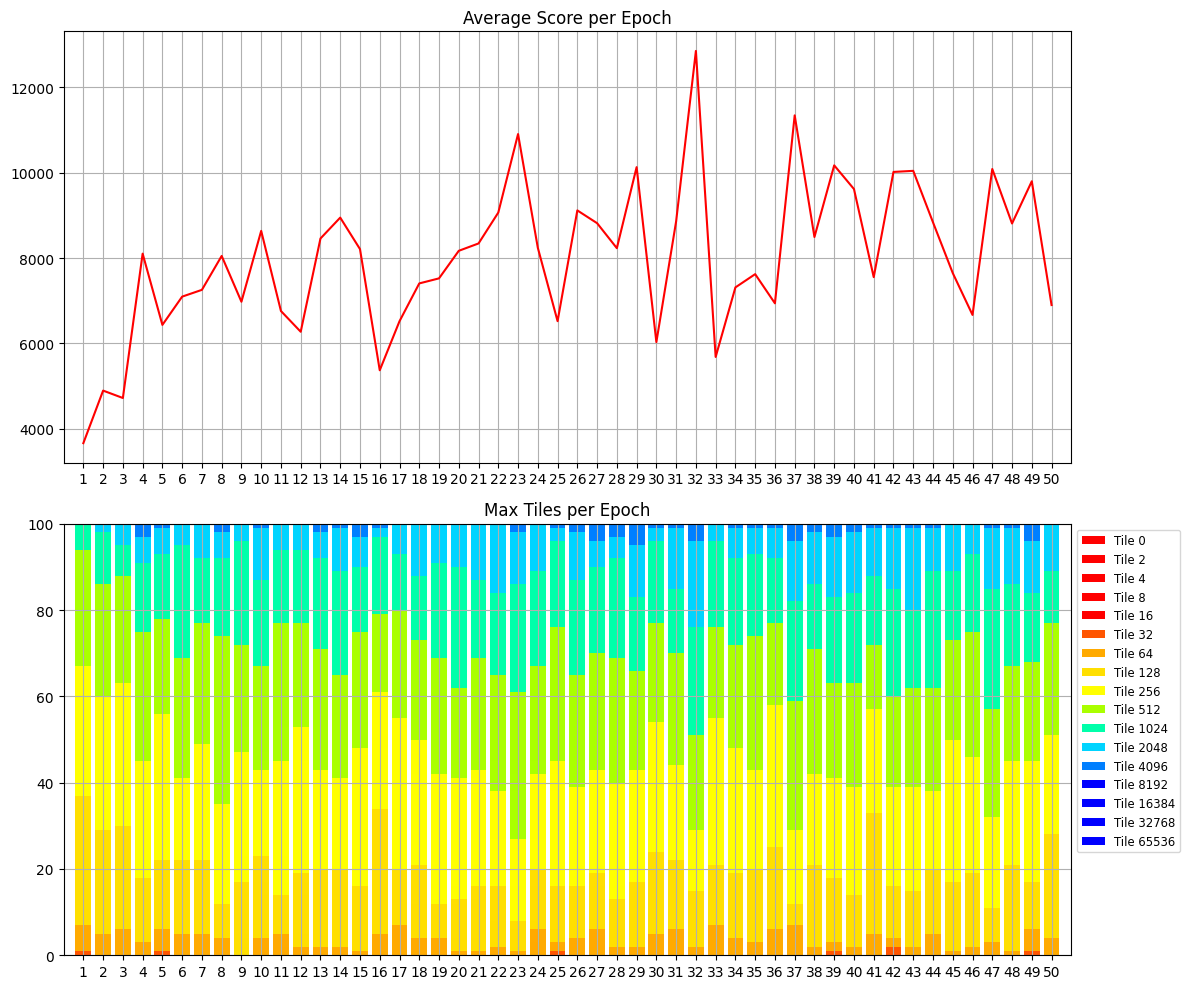

In [6]:
import matplotlib.pyplot as plt

epochs = np.arange(1, num_epochs + 1)

# colors = [
#     '#ff0000', #0
#     '#ff2a00', #2
#     '#ff5500', #4
#     '#ff7f00', #8
#     '#ffaa00', #16
#     '#ffd400', #32
#     '#ffff00', #64
#     '#aaff00', #128
#     '#55ff00', #256
#     '#00ff00', #512
#     '#00ff55', #1024
#     '#00ffaa', #2048
#     '#00d4ff', #4096
#     '#00aaff', #8192
#     '#007fff', #16384
#     '#0055ff', #32768
#     '#0000ff'  #65536
# ]
colors = [
    '#ff0000', #0
    '#ff0000', #2
    '#ff0000', #4
    '#ff0000', #8
    '#ff0000', #16
    '#ff5500', #32
    '#ffaa00', #64
    '#ffdf00', #128
    '#ffff00', #256
    '#aaff00', #512
    '#00ffaa', #1024
    '#00d4ff', #2048
    '#007fff', #4096
    '#0000ff', #8192
    '#0000ff', #16384
    '#0000ff', #32768
    '#0000ff', #65536
]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(epochs, avg_scores, label="Average Score", color="red")
ax1.set_title("Average Score per Epoch")
ax1.grid(True)
ax1.set_xticks(epochs)
ax1.tick_params(labelbottom=True)

bottom = np.zeros(num_epochs)
for i in range(17):
    if (i == 0):
        ax2.bar(epochs, tile_distribution[:, i], bottom=bottom, label=f'Tile 0', color=colors[i])
    else: ax2.bar(epochs, tile_distribution[:, i], bottom=bottom, label=f'Tile {2**i}', color=colors[i])
    bottom += tile_distribution[:, i]

ax2.set_title("Max Tiles per Epoch")
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize="small")
ax2.grid(True)

ax1.set_xlim(0, num_epochs+1)
ax2.set_xlim(0, num_epochs+1)

plt.tight_layout()
plt.show()

# Load from Best Epoch

In [7]:
best_epoch = int(np.argmax(avg_scores))
model_path = os.path.join(save_dir, f"model_epoch_{best_epoch + 1}.pth")
model.load_state_dict(torch.load(model_path))
print("Loaded from: ", model_path)

Loaded from:  saved_models/model_epoch_32.pth


# Predictions

In [8]:
import itertools

y_pred = []
y_test = []
correct = 0
total = 0
results = [0,0,0,0]

"""
We're not training so we don't need to calculate the gradients for our outputs
"""
with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)  # Get model outputs
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_test.extend(y.tolist())
        correct += (predicted == y).sum().item()
        total += y.size(0)
        for pred in predicted:
            results[pred.item()] += 1

print(f'Accuracy: {100 * correct // total}%')
print(f'Prediction distribution:')
print(f'0:  {results[0]}')
print(f'1:  {results[1]}')
print(f'2:  {results[2]}')
print(f'3:  {results[3]}')

Accuracy: 90%
Prediction distribution:
0:  96652
1:  59144
2:  20412
3:  61242


# Export Imitation to ONNX

In [9]:
import torch.onnx
dummy_input = torch.randn(1, 1, 4, 4) #batch, channels, height, width for cnn
torch.onnx.export(model, dummy_input, "2048_imitation.onnx", input_names=["input"], output_names=["output"])

# Convert Imitation ONNX to Tensorflow to Tensorflow.js

the package versions need to be really specific or else it crashes and burns

make two new virtual envs with the following:\
`python3.9 -m venv tfenv && python3.9 -m venv tfjsenv`

run this bash script to set up required packages in the two enviornments:\
`source tfenv/bin/activate && pip install tensorflow==2.13.0 keras==2.13.1 onnx==1.14.0 onnx-tf==1.10.0 protobuf==3.20.3 tensorflow-probability==0.20.0 &&deactivate && source tfjsenv/bin/activate && pip install tensorflow==2.13.0 keras==2.13.1 onnx==1.14.0 onnx-tf==1.10.0 protobuf==3.20.3 tensorflow-probability==0.20.0 && pip install tensorflowjs==4.18.0 && deactivate`

run this bash script to convert ONNX to Tensorflow, then to Tensorflow.js:\
`source tfenv/bin/activate && cd model && onnx-tf convert -i 2048_imitation.onnx -o 2048_imitation_tf && cd ../ && deactivate && source tfjsenv/bin/activate && cd model && tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model 2048_imitation_tf/ 2048_imitation_tfjs/ && cd ../ && deactivate`

# Finetuning

In [10]:
from torch.distributions import Categorical

model.eval()
env = Game2048Env()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_episodes = 10000
baseline = 1500
batch_size = 25
batch_log_probs = []
batch_improvs = []

for episode in range(num_episodes):
    state = env.reset()
    done = False

    valid_log_probs = []
    finalscore = 0

    while not done:
        board = state.copy().flatten(order='F')
        state_tensor = torch.tensor(board, dtype=torch.float32).reshape(-1, 1, 4, 4)
        logits = model(state_tensor)

        ranked_actions = torch.argsort(logits, dim=1, descending=True)[0]   #sort by how liikely move is

        original_board = env.board.copy()
        final_action = None
        selected_log_prob = None

        movecount = 0   #tracks if the first move was valid 
        for action in ranked_actions:
            test_board, _ = move(original_board.copy(), action.item())
            if not np.array_equal(test_board, original_board):
                final_action = action.item()
                dist = Categorical(logits=logits)
                selected_log_prob = dist.log_prob(action)
                break
            movecount += 1

        if final_action is None:    #game is stuck, skip (shouldn't happen)
            print("SOMETHING WRONG AAAAAUUEEUAGHGEUGHHH")
            break

        state, score, done = env.step(final_action)
        valid_log_probs.append(selected_log_prob)
        finalscore += score

    # use baseline to force games to improve
    baseline = 0.95 * baseline + 0.05 * finalscore
    improvement= finalscore - baseline + 0.1 * len(valid_log_probs)

    #use batches for more stable training
    batch_log_probs.extend(valid_log_probs)
    batch_improvs.extend([improvement] * len(valid_log_probs))

    if (episode+1) % batch_size == 0:
        loss = 0
        for log_prob, improvement in zip(batch_log_probs, batch_improvs):
            loss -= log_prob * improvement
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_log_probs = []
        batch_improvs = []

    if (episode+1) % 50 == 0:
        print(f"Episode {episode+1}, Max Tile: {env.board.max()}, Final Score: {finalscore},  Baseline: {baseline:.2f}, Improvement: {improvement:.2f}")

Episode 50, Max Tile: 9, Final Score: 7304,  Baseline: 7907.78, Improvement: -553.88
Episode 100, Max Tile: 10, Final Score: 9824,  Baseline: 8804.49, Improvement: 1075.91
Episode 150, Max Tile: 9, Final Score: 4480,  Baseline: 9004.42, Improvement: -4494.22
Episode 200, Max Tile: 7, Final Score: 2660,  Baseline: 11433.87, Improvement: -8749.87
Episode 250, Max Tile: 7, Final Score: 1472,  Baseline: 13571.98, Improvement: -12084.28
Episode 300, Max Tile: 7, Final Score: 2112,  Baseline: 9952.36, Improvement: -7820.96
Episode 350, Max Tile: 9, Final Score: 7092,  Baseline: 9106.74, Improvement: -1966.34
Episode 400, Max Tile: 7, Final Score: 1224,  Baseline: 8992.43, Improvement: -7755.03
Episode 450, Max Tile: 11, Final Score: 24420,  Baseline: 10216.44, Improvement: 14324.86
Episode 500, Max Tile: 8, Final Score: 2448,  Baseline: 8623.52, Improvement: -6155.02
Episode 550, Max Tile: 12, Final Score: 44880,  Baseline: 10188.97, Improvement: 34884.73
Episode 600, Max Tile: 8, Final Scor

# Compare Finetuned with Imitation

100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


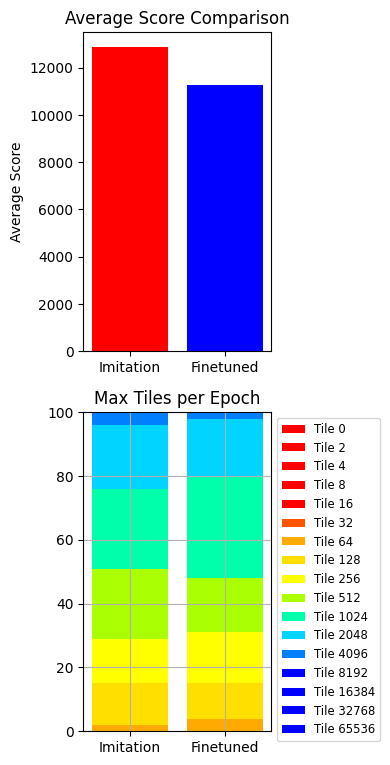

In [11]:
model_path = os.path.join(save_dir, "finetuned.pth")
torch.save(model.state_dict(), model_path)
model.eval()
avg_fine = 0
fine_distribution = np.zeros(17)
best_score = avg_scores[best_epoch]
best_distribution = tile_distribution[best_epoch]

for i in tqdm(range(100)):  #run 100 times to also get distributions
    env = Game2048Env()
    state = env.reset()
    done = False
    score = 0
    while not done:
        board = state.copy().flatten(order='F')
        state_tensor = torch.tensor(board, dtype=torch.float32).reshape(-1, 1, 4, 4)
        logits = model(state_tensor)
        ranked_actions = torch.argsort(logits, dim=1, descending=True)[0]
        original_board = env.board.copy()
        final_action = None
        for action in ranked_actions:
            test_board, _ = move(original_board.copy(), action.item())
            if not np.array_equal(test_board, original_board):
                final_action = action.item()
                break
        state, reward, done = env.step(final_action)
        score += reward
    avg_fine += score/100
    fine_distribution[env.board.max()] += 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

ax1.bar(["Imitation", "Finetuned"], [best_score, avg_fine], color=["red", "blue"])
ax1.set_ylabel("Average Score")
ax1.set_title("Average Score Comparison")
ax1.tick_params(labelbottom=True)

distribution = np.stack((best_distribution, fine_distribution), axis=1)
finecomp = np.arange(2)
bottom = np.zeros(2)
for i in range(17):
    if (i == 0):
        ax2.bar(finecomp, distribution[i], bottom=bottom, label=f'Tile 0', color=colors[i])
    else: ax2.bar(finecomp, distribution[i], bottom=bottom, label=f'Tile {2**i}', color=colors[i])
    bottom += distribution[i]

ax2.set_title("Max Tiles Comparison")
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize="small")
ax2.grid(True)
plt.tight_layout()
plt.show()

# Export Finetuned to ONNX

In [12]:
import torch.onnx
dummy_input = torch.randn(1, 1, 4, 4) #batch, channels, height, width for cnn
torch.onnx.export(model, dummy_input, "2048_fine.onnx", input_names=["input"], output_names=["output"])

# Convert Finetuned ONNX to Tensorflow to Tensorflow.js

you know the drill...

run this bash script to convert ONNX to Tensorflow to Tensorflow.js:\
`source tfenv/bin/activate && cd model && onnx-tf convert -i 2048_fine.onnx -o 2048_fine_tf && cd ../ && deactivate && source tfjsenv/bin/activate && cd model && tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model 2048_fine_tf/ 2048_fine_tfjs/ && cd ../ && deactivate`